In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path="/content/gdrive/MyDrive/CPSC536R/Project/sparse-vae-code"
os.chdir(path)
os.listdir(path)

In [ ]:
%%capture _ 

!python -m pip install scanpy
!python -m pip install bottleneck

In [ ]:
os.kill(os.getpid(), 9)

In [ ]:
import numpy as np
import pandas as pd
from importlib import reload
import itertools as it
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import plotnine as p
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.feature_selection import mutual_info_regression

In [ ]:
import torch
from model.models import DSVAE
from model.models import SparseVAESpikeSlab, VAE
import scipy
from torch.nn import functional as F
from torch.utils.data import DataLoader
from scipy.stats import chi2
import torch.optim as optim

In [ ]:
# preprocess data
data_pth = "../data/"

zeisel = sc.read(data_pth + 'Zeisel.h5ad')
zeisel
### AnnData object with n_obs × n_vars = 3005 × 20006

# normalize
sc.pp.normalize_total(zeisel, target_sum=1, inplace=False)['X']
# logaritmize
sc.pp.log1p(zeisel)

sc.pp.highly_variable_genes(
    zeisel, n_top_genes=5000, subset=True
)

zeisel.write('filtered_zeisel.h5ad')

x = zeisel.X
zeisel

AnnData object with n_obs × n_vars = 3005 × 5000
    obs: 'tissue', 'group #', 'total mRNA mol', 'well', 'sex', 'age', 'diameter', 'cell_id', 'level1class', 'level2class'
    var: 'featureType', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'log1p', 'hvg'

In [ ]:
data_pth = "../data/"
zeisel = sc.read(data_pth + 'filtered_zeisel.h5ad')
x = zeisel.X

### Utils

In [ ]:
def visualize_mask_as_topics(num_genes=10):
    W = model.get_generator_mask().cpu().detach().numpy()
    n_components = W.shape[1]
    zeisel.var["topic"] = 0
    top_genes = []
    for k in range(n_components):
        w = W[:,k]
        w = np.abs(w)
        top_gene = (-w).argsort()
        for t in top_gene:
            zeisel.var['topic'][t] = k
        topic_genes = [(zeisel.var_names[t], w[t]) for t in top_gene[:num_genes]]
        print('Topic {}: {}'.format(k, topic_genes[:10]))
        top_genes.append(list(top_gene))
    return top_genes


## Jaccard Index
def jaccard(X1, X2, num_variances):
  x_vars = np.var(X1, axis=0)
  recon_vars = np.var(X2, axis=0)

  x_top_vars = getTopVariances(x_vars, num_variances)
  recon_top_vars = getTopVariances(recon_vars, num_variances)
  return len(x_top_vars & recon_top_vars)/len(x_top_vars | recon_top_vars)

def getTopVariances(arr, num_variances):
  assert num_variances <= len(arr)
  arr_copy = arr.copy()

  indices = set()
  for i in range(num_variances):
    idx = np.argmax(arr_copy)
    indices.add(idx)
    arr_copy[idx] = -1
  return indices


def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained


def mutual_information_gap(df, h_list, z_list):
    mig = []
    for i in range(len(z_list)):
        mig.append(individual_mig(df, z_list[i], z_list[:i] + z_list[i+1:]))
    return np.mean(mig)
# calculate the MIG for a single h_k
def individual_mig(df, h_k, z_list):
    mutual_information = mutual_info_regression(df[z_list], df[h_k])
    first = np.max(mutual_information)
    second = np.max(mutual_information[mutual_information != first])
    return first - second


def plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx):
    plt.figure(figsize=(7, 12))
    for i in range(3):
        plt.subplot(3, 2, 2*i + 1)

        plt.hist2d(
        Z_df_ordered[f'z{2*i}'], Z_df_ordered[f'z{2*i + 1}'],
        norm= mcolors.PowerNorm(0.25),
        cmap= "gray_r",
        rasterized=True
        )
        plt.axis('equal');
        plt.xlabel(f'$Z_{2*i}$ ({variance_explained[idx][2*i]:.1%} variance)')
        plt.ylabel(f'$Z_{2*i + 1}$ ({variance_explained[idx][2*i + 1]:.1%} variance)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


        # -- W plot --
        plt.subplot(3, 2, 2 * i + 2)

        w_columns = [f'w{2*i}', f'w{2*i + 1}']

        plt.scatter(
            W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]], s=5, c='lightgrey',
            rasterized=True
        )
        plt.xlabel(f'$W_{2*i}$')
        plt.ylabel(f'$W_{2*i + 1}$')

        tmp_ = W_df_ordered.copy()
        tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)

        ggg = (
            tmp_
            .sort_values('lnth', ascending=False)
            .head(5)[['lnth', *w_columns]]
        )
        ggg['gene_name'] = ggg.index
        print(ggg['gene_name'].values)

        texts = []
        arrows = []
        for g, r in ggg.iterrows():
            x_, y_ = r[w_columns[0]], r[w_columns[1]]
            # print(x_, y_)
            
            ha = 'right'
            if x_ > 0:
                ha = 'left'
                
            va = 'top'
            if y_ > 0:
                va = 'bottom'
                
            arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, width=0.0001))
            
            xs, ys = 0, 0
            # if (i, r.gene_name) in text_shift:
            #     xs, ys = text_shift[(i, r.gene_name)]
            
            texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.tight_layout()

def z_cov_plot(ZTZ, variance_explained, idx):
    plt.figure(figsize=(5,5))
    
    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(5, 5, wspace=0.0, hspace=0.0)

    ax_bottom = fig.add_subplot(gs[1:, :4])
    ax_bottom.axis('equal')

    ax_bottom.axis('off')

    pc = ax_bottom.pcolormesh(ZTZ[:, idx][idx], cmap=cm.Greys, vmin=-1, vmax=1, rasterized=True)
    
    ax_bottom.invert_yaxis()
    
    ax_right = fig.add_subplot(gs[1:, 4])
    
    ax_right.axis('off')
    
    axins = inset_axes(
        ax_right,
        width="10%",
        height="50%",
        loc='lower left',
        bbox_to_anchor=(0., 0.25, 1, 1),
        bbox_transform=ax_right.transAxes,
        borderpad=0
    )
    
    cb = fig.colorbar(pc, cax=axins)
    cb.solids.set_rasterized(True)
    axins.set_ylabel('Covariance')
    return fig


### DSVAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_type = 'DS'
# model_type = 'VAE'
# model_type = 'spikeslab'
n_components = 15

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 512
nepoch = 200

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

x_np = x
sigmas_init = np.std(x_np, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

if model_type == 'DS':
    model = DSVAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim, beta_vae=2, row_normalized = True)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        if model_type != 'DS':
            rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
            loss = rec_loss + kl_loss + sig_loss + reg_loss
        else:
            rec_loss, kl_loss, reg_loss = model.vae_loss(data.to(device))
            loss = rec_loss + kl_loss + reg_loss

        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab' or model_type == 'DS':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                               (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) + (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}", "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: 24.8 Likelihood: 0.858 KL loss: 0.0689 W loss: 23.9
Epoch: 10 Total loss: 16.5 Likelihood: 0.33 KL loss: 0.000174 W loss: 16.2
Epoch: 20 Total loss: 12.7 Likelihood: 0.189 KL loss: 1.33e-05 W loss: 12.5
Epoch: 30 Total loss: 11.0 Likelihood: 0.129 KL loss: 5.51e-06 W loss: 10.8
Epoch: 40 Total loss: 9.55 Likelihood: 0.0935 KL loss: 4.44e-06 W loss: 9.46
Epoch: 50 Total loss: 8.39 Likelihood: 0.0726 KL loss: 1.19e-06 W loss: 8.31
Epoch: 60 Total loss: 7.29 Likelihood: 0.0563 KL loss: 2.7e-06 W loss: 7.24
Epoch: 70 Total loss: 5.93 Likelihood: 0.0459 KL loss: 2.68e-06 W loss: 5.88
Epoch: 80 Total loss: 4.8 Likelihood: 0.0385 KL loss: 7.22e-07 W loss: 4.76
Epoch: 90 Total loss: 3.68 Likelihood: 0.0332 KL loss: 1.1e-06 W loss: 3.65
Epoch: 100 Total loss: 2.82 Likelihood: 0.0291 KL loss: 5.54e-07 W loss: 2.79
Epoch: 110 Total loss: 2.3 Likelihood: 0.0256 KL loss: 1.08e-07 W loss: 2.28
Epoch: 120 Total loss: 2.0 Likelihood: 0.0219 KL loss: 2.21e-07 W loss: 1.98
Epoch: 13

In [ ]:
out_dir = "out/zeisel/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
torch.save(model.state_dict(), "out/" + "zeisel" + model_type)

z_mean, logvar = model.encode(torch.tensor(x, dtype=torch.float).to(device))

np.savetxt(out_dir + "/" + model_type + "_z_mean.csv", z_mean.detach().cpu().numpy(), delimiter=",")
np.savetxt(out_dir + "/" + model_type + "_sigmas.csv", model.log_sigmas.detach().cpu().exp().numpy(), delimiter=",")

if model_type=='spikeslab' or model_type == 'DS':
    np.savetxt(out_dir + "/" + model_type + "_W.csv", model.W.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_p_star.csv", model.p_star.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_thetas.csv", model.thetas.detach().cpu().numpy(), delimiter=",")


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
x_loss

array(0.01001365, dtype=float32)

In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

0.6642396505096734

In [ ]:
key_genes = visualize_mask_as_topics()
np.savetxt('DSVAE_topicGenes.txt', key_genes)

<ipython-input-6-83152b04f435>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Topic 0: [('Plcb4', 0.33868825), ('Ssu2', 0.33143836), ('Mir3069', 0.3232527), ('Itpripl2', 0.3178108), ('Folr1', 0.31485662), ('Slc25a32', 0.30126292), ('Smim5', 0.300769), ('A230077H06Rik', 0.30011383), ('Cpa6', 0.28252253), ('Ube2z', 0.28247267)]
Topic 1: [('2900060B14Rik', 0.37656167), ('Pmp22', 0.3455425), ('Cped1', 0.3111756), ('Olfm3', 0.30898854), ('Atp8b1', 0.30885345), ('Hist1h3e', 0.3059437), ('Clstn2', 0.30236465), ('Il23a', 0.29711592), ('Zfp14', 0.29572207), ('6330403K07Rik', 0.2890143)]
Topic 2: [('Crabp1', 0.34721488), ('Lima1', 0.31975204), ('Stat5b', 0.31442475), ('Tbc1d30', 0.31282848), ('Cpne5', 0.30280268), ('Mir344c', 0.30205914), ('8430408G22Rik', 0.298744), ('Cxcl12', 0.29490304), ('Arc', 0.28440094), ('Foxh1', 0.27744317)]
Topic 3: [('Tpm1', 0.38095617), ('Tescl', 0.37304333), ('Tdh', 0.3263141), ('Zfp474', 0.31840745), ('Usf2', 0.3054477), ('Ccdc40', 0.30509445), ('Pex7', 0.2999092), ('4930431F12Rik', 0.2912511), ('Klhl13', 0.28925627), ('Sharpin', 0.2889455)]

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
W

array([[0.01785981, 0.06115704, 0.04172776, ..., 0.0387678 , 0.05673883,
        0.05962916],
       [0.10156304, 0.07931675, 0.00124577, ..., 0.00524537, 0.14185266,
        0.19922742],
       [0.09362888, 0.01707328, 0.04437064, ..., 0.0481948 , 0.04456906,
        0.07560893],
       ...,
       [0.1596471 , 0.04630982, 0.08997247, ..., 0.04812076, 0.07598957,
        0.01061223],
       [0.00469319, 0.01123423, 0.1067456 , ..., 0.02926778, 0.11845686,
        0.03515955],
       [0.10279577, 0.08244125, 0.04241282, ..., 0.04105593, 0.11184885,
        0.09456563]], dtype=float32)

In [ ]:
out_dir = "out/zeisel/"
model_type = 'DS'

In [ ]:
# z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
z = z_mean.detach().cpu().numpy()
ZTZ, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([3.76900541e-01, 2.57629907e-01, 1.40026845e-01, 8.10345106e-02,
       5.93412214e-02, 2.91552237e-02, 2.35369073e-02, 1.92413732e-02,
       9.35859346e-03, 2.70845867e-03, 1.06087446e-03, 1.98012980e-06,
       1.62908348e-06, 7.88888323e-07, 1.14595926e-06])

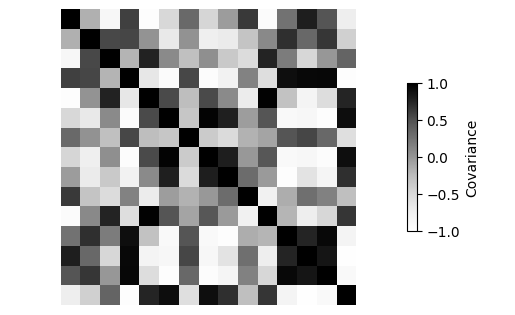

<Figure size 500x500 with 0 Axes>

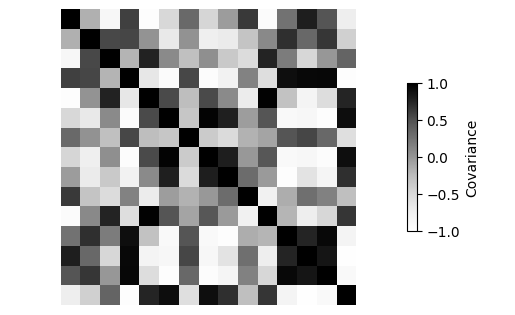

In [ ]:

z_cov_plot(ZTZ, variance_explained, idx)

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

1.414452236750436

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
# W = pd.read_csv(out_dir + "/" + model_type + "_W.csv", delimiter=",", header=None)
W_df = pd.DataFrame(W).add_prefix('w')
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = zeisel.var_names
W_df_ordered = zeisel.var.loc[W_df_ordered.index].join(W_df_ordered)


['2900060B14Rik' 'Trpc6' 'Pmp22' 'Plcb4' 'Mir3069']
['Tpm1' 'Tescl' 'Crabp1' 'Stat5b' 'Ccdc40']
['Dmrtc1c1_loc2' 'Trip6' 'Sarm1' 'Megf11' 'Gpr126']


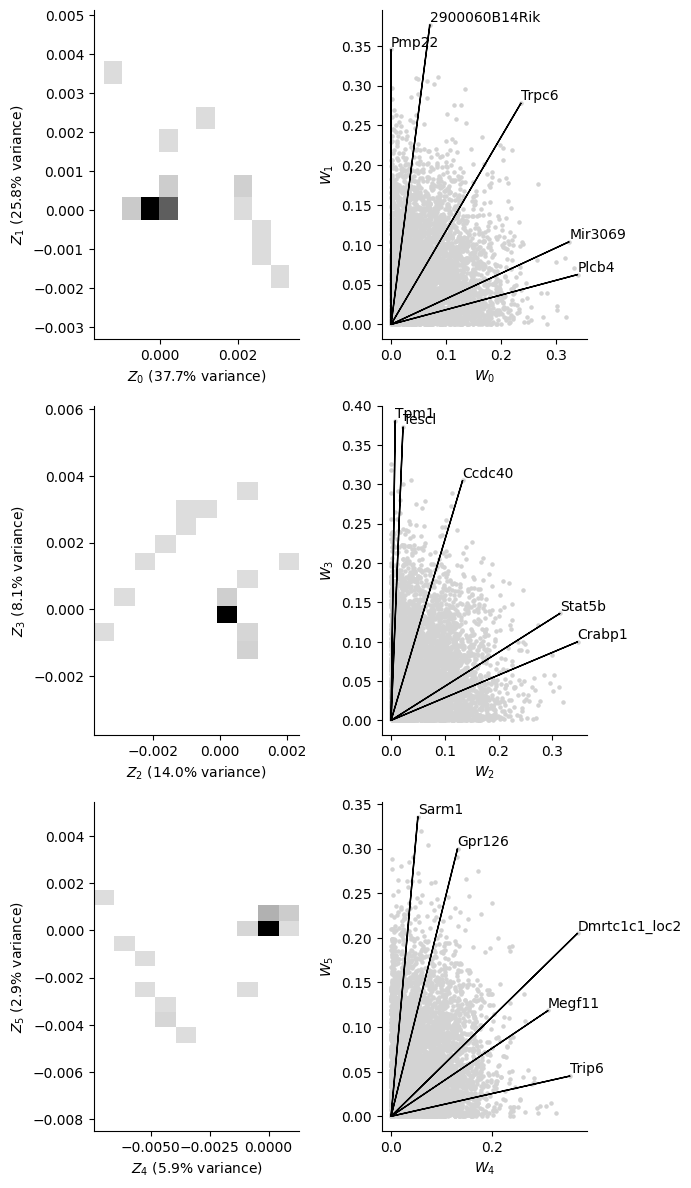

In [ ]:
plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx)

### sparse VAE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model_type = 'DS'
model_type = 'VAE'
# model_type = 'spikeslab'
n_components = 15

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 512
nepoch = 100

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

x_np = x
sigmas_init = np.std(x_np, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

z_prior='standard'
if model_type == 'spikeslab':
    model = SparseVAESpikeSlab(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, lambda0=lambda0, lambda1=lambda1, row_normalize=False)
if model_type == 'vae':
    model = VAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, beta_vae=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
        loss = rec_loss + kl_loss + sig_loss + reg_loss
        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                               (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) + (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}", "sig loss:", f"{sig_loss.detach().item():.3}", "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: -7.26e+03 Likelihood: 0.71 KL loss: 0.0498 sig loss: -7.38e+03 W loss: 1.22e+02
Epoch: 10 Total loss: -1.03e+04 Likelihood: 1.8 KL loss: 0.000183 sig loss: -1.04e+04 W loss: 69.6
Epoch: 20 Total loss: -1.34e+04 Likelihood: 6.32 KL loss: 2.89e-05 sig loss: -1.34e+04 W loss: 34.2
Epoch: 30 Total loss: -1.64e+04 Likelihood: 18.9 KL loss: 1.06e-05 sig loss: -1.64e+04 W loss: 15.2
Epoch: 40 Total loss: -1.93e+04 Likelihood: 67.3 KL loss: 5.95e-06 sig loss: -1.94e+04 W loss: 5.78
Epoch: 50 Total loss: -2.19e+04 Likelihood: 1.97e+02 KL loss: 4.17e-06 sig loss: -2.21e+04 W loss: 2.54
Epoch: 60 Total loss: -2.39e+04 Likelihood: 5.8e+02 KL loss: 3.67e-06 sig loss: -2.45e+04 W loss: 1.94
Epoch: 70 Total loss: -2.49e+04 Likelihood: 1.24e+03 KL loss: 2.87e-06 sig loss: -2.61e+04 W loss: 1.84
Epoch: 80 Total loss: -2.51e+04 Likelihood: 1.83e+03 KL loss: 2.04e-06 sig loss: -2.69e+04 W loss: 1.77
Epoch: 90 Total loss: -2.51e+04 Likelihood: 2.02e+03 KL loss: 1.72e-06 sig loss: -2.7

In [ ]:
# Sparse VAE without sigma-loss

model_type = 'spikeslab'
n_components = 15


Epoch: 0 Total loss: 1.24e+02 Likelihood: 0.619 KL loss: 0.0416 W loss: 1.23e+02
Epoch: 10 Total loss: 70.6 Likelihood: 0.223 KL loss: 0.000208 W loss: 70.3
Epoch: 20 Total loss: 34.9 Likelihood: 0.126 KL loss: 7.7e-05 W loss: 34.7
Epoch: 30 Total loss: 15.4 Likelihood: 0.0906 KL loss: 2.87e-05 W loss: 15.3
Epoch: 40 Total loss: 5.98 Likelihood: 0.0659 KL loss: 1.16e-05 W loss: 5.91
Epoch: 50 Total loss: 2.77 Likelihood: 0.0537 KL loss: 9.31e-06 W loss: 2.72
Epoch: 60 Total loss: 2.02 Likelihood: 0.0405 KL loss: 1.41e-05 W loss: 1.98
Epoch: 70 Total loss: 1.9 Likelihood: 0.0348 KL loss: 4.79e-06 W loss: 1.86
Epoch: 80 Total loss: 1.81 Likelihood: 0.0306 KL loss: 2.3e-05 W loss: 1.78
Epoch: 90 Total loss: 1.77 Likelihood: 0.0262 KL loss: 1.67e-06 W loss: 1.74


In [ ]:
out_dir = "out/zeisel/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
torch.save(model.state_dict(), "out/" + "zeisel" + model_type)

z_mean, logvar = model.encode(torch.tensor(x, dtype=torch.float).to(device))

np.savetxt(out_dir + "/" + model_type + "_z_mean.csv", z_mean.detach().cpu().numpy(), delimiter=",")
np.savetxt(out_dir + "/" + model_type + "_sigmas.csv", model.log_sigmas.detach().cpu().exp().numpy(), delimiter=",")

if model_type=='spikeslab':
    np.savetxt(out_dir + "/" + model_type + "_W.csv", model.W.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_p_star.csv", model.p_star.detach().cpu().numpy(), delimiter=",")
    np.savetxt(out_dir + "/" + model_type + "_thetas.csv", model.thetas.detach().cpu().numpy(), delimiter=",")


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
print(x_loss)


array(1959.0457, dtype=float32)

In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
print(x_loss)


0.023919433


In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

{2051, 6, 2055, 2054, 2058, 2061, 13, 2063, 16, 2066, 19, 2068, 2067, 2069, 20, 18, 2071, 2074, 27, 2076, 2077, 2078, 2079, 2080, 33, 2081, 32, 36, 2085, 2082, 2087, 2083, 2090, 2091, 2093, 46, 2095, 2097, 2099, 2100, 2101, 54, 55, 2103, 2105, 57, 2107, 2108, 61, 2110, 2104, 58, 2113, 2114, 2115, 63, 69, 2118, 2116, 2120, 2119, 2125, 77, 79, 2127, 81, 2130, 84, 85, 2133, 87, 88, 89, 2140, 2141, 2142, 2143, 96, 2148, 2149, 113, 116, 2165, 28, 29, 2196, 155, 163, 164, 165, 167, 2216, 2217, 170, 2219, 173, 2222, 175, 2224, 177, 178, 2227, 2225, 2229, 2230, 2231, 2232, 4276, 182, 2235, 2236, 2237, 187, 2233, 2240, 2239, 2242, 194, 2245, 2246, 2248, 2249, 2250, 2251, 2252, 202, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 213, 220, 222, 224, 226, 231, 232, 2281, 2284, 237, 236, 238, 240, 241, 2290, 243, 242, 245, 246, 2291, 244, 2288, 250, 2299, 251, 2298, 252, 2301, 2304, 257, 2306, 2307, 260, 2309, 262, 2311, 2310, 2308, 2313, 267, 259, 268, 270, 271, 272, 273, 274, 2323, 276, 277, 278

0.7574692442882249

In [ ]:
key_genes = visualize_mask_as_topics()
np.savetxt('sparseVAE_topicGenes.txt', key_genes)

<ipython-input-72-75209c9b9f5b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeisel.var['topic'][t] = k


Topic 0: [('Hebp1', 0.007054887), ('Gtpbp8', 0.006505575), ('Itm2a', 0.006053691), ('Frmd8', 0.0060385643), ('Cpe', 0.0058125034), ('mt-Tl2', 0.005679993), ('Dleu7', 0.0056607863), ('Grsf1', 0.0052943085), ('Sema4f', 0.00525994), ('Ccl21a_loc1', 0.0052365097)]
Topic 1: [('Ptprt', 0.006818716), ('Pdxk', 0.0067436793), ('Scube1', 0.0066955118), ('Crispld2', 0.005775822), ('Plcb3', 0.0057245526), ('Neto1', 0.0056885155), ('Plxnb1', 0.0056613726), ('Gstm3', 0.0054839617), ('Foxc1', 0.0054645925), ('Wipf1', 0.0051345383)]
Topic 2: [('Grin3a', 0.0066513945), ('Dse', 0.006633528), ('Best1', 0.006630433), ('Tacr3', 0.0065868865), ('Mir5129', 0.0064071217), ('Fastkd5', 0.0058776853), ('Ccdc108', 0.005575256), ('Wdr78', 0.005536653), ('Mapk11', 0.0053738095), ('Calca', 0.005371075)]
Topic 3: [('Ocln', 0.0070369896), ('Mcam', 0.006860479), ('Hapln1', 0.006857356), ('Klc4', 0.006786697), ('Ankrd42', 0.0067717433), ('Ly6g6f', 0.006583799), ('Pcdha5', 0.0064074392), ('Nckap5l', 0.005769042), ('Gas2l

In [ ]:
# plot the latent dimension coordinates for each cell
zeisel.obsm["X_spvae"] = z_mean.cpu().detach().numpy()
sc.pp.neighbors(zeisel, use_rep="X_spvae", n_neighbors=20)
sc.tl.umap(zeisel, min_dist=0.3)



/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


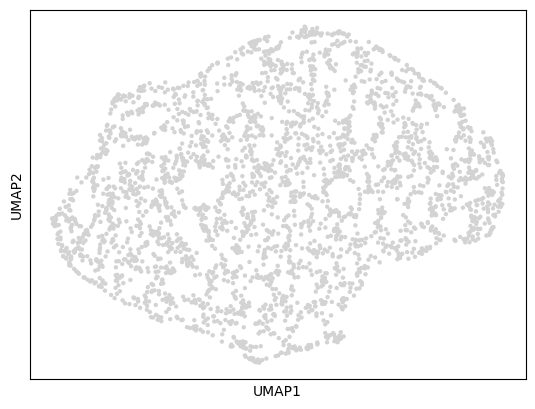

In [ ]:
sc.pl.umap(zeisel, ncols=3)

In [ ]:
W = model.get_generator_mask().cpu().detach().numpy()
W

array([[-1.5984927e-03,  2.3499431e-04, -3.5346524e-04, ...,
        -1.8596169e-05, -1.1661575e-03, -4.0155152e-04],
       [-1.9158289e-03, -7.2428270e-04, -1.6337464e-03, ...,
        -7.8388641e-04,  1.4516818e-03, -3.5093605e-04],
       [ 5.0115993e-04, -1.8453657e-03, -1.1107378e-03, ...,
         1.0810594e-05,  3.3205541e-04,  8.3846995e-04],
       ...,
       [ 8.6027163e-04,  1.9391520e-05, -1.1826331e-03, ...,
         6.0486922e-04, -2.0103725e-03,  8.9135609e-04],
       [ 3.0087588e-06, -7.4562570e-04,  4.1728438e-04, ...,
        -2.0860853e-04,  1.8917463e-05, -1.5752293e-04],
       [ 5.0288561e-04,  1.7654894e-04,  2.7263126e-05, ...,
        -2.6666063e-03, -1.5061759e-04,  4.2344694e-04]], dtype=float32)

In [ ]:
out_dir = "out/zeisel/"
model_type = 'spikeslab'

In [ ]:
z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
# z = z_mean.detach().cpu().numpy()
_, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([4.95270816e-01, 3.96088635e-01, 6.69760801e-02, 2.28430371e-02,
       1.29744176e-02, 5.84612964e-03, 1.31419285e-07, 1.27420119e-07,
       6.27007048e-08, 1.14839690e-07, 1.08311438e-07, 7.15912718e-08,
       8.11572178e-08, 9.59728916e-08, 9.12551285e-08])

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.7305589787617836

In [ ]:
# W = model.get_generator_mask().cpu().detach().numpy()
W = pd.read_csv(out_dir + "/" + model_type + "_W.csv", delimiter=",", header=None)
W_df = pd.DataFrame(W).add_prefix('w')
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = zeisel.var_names
W_df_ordered = zeisel.var.loc[W_df_ordered.index].join(W_df_ordered)


['Hebp1' 'Ptprt' 'Pdxk' 'Scube1' 'Gtpbp8']
['Hapln1' 'Pcdha5' 'Tacr3' 'Fastkd5' 'Grin3a']
['Klc2' 'Cdk5rap1' 'Stxbp3a' 'Tph1' 'Samd4']


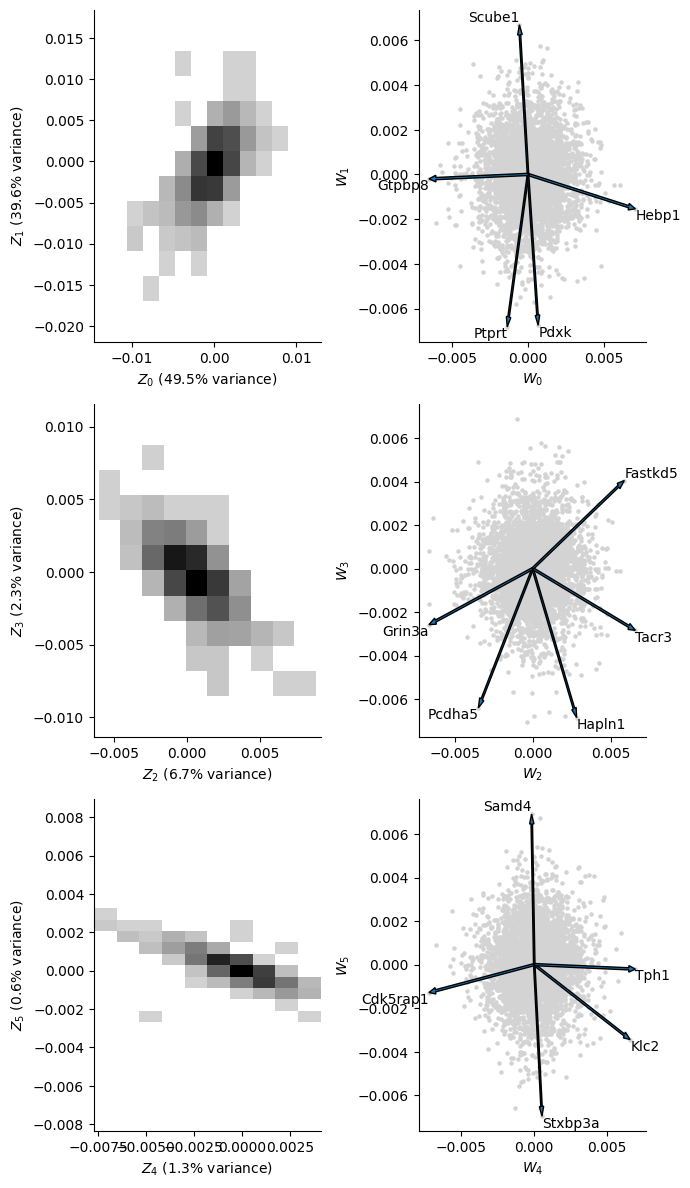

In [ ]:
plot_genes(Z_df_ordered, W_df_ordered, variance_explained, idx)

### Beta VAE

In [ ]:
# Beta-vae (beta=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# model_type = 'DS'
model_type = 'VAE'
# model_type = 'spikeslab'
n_components = 15

input_dim = x.shape[1]
latent_dim = n_components
batch_size = 512
nepoch = 100

hidden_dim = 128

lambda1 = 1
lambda0 = 10
a=1
b=input_dim

lr=1e-2

x_np = x
sigmas_init = np.std(x_np, axis=0)
sig_quant = 0.9
sig_df = 3

sig_est = np.quantile(sigmas_init, q=0.05)
if sig_est==0:
    sig_est = 1e-3

q_chi = chi2.ppf(1-sig_quant, sig_df)
sig_scale = sig_est * sig_est * q_chi / sig_df

z_prior='standard'
if model_type == 'spikeslab':
    model = SparseVAESpikeSlab(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, lambda0=lambda0, lambda1=lambda1, row_normalize=False)
if model_type == 'VAE':
    model = VAE(batch_size, input_dim, latent_dim, hidden_dim=hidden_dim,z_prior=z_prior,sigma_prior_scale=sig_scale,
                                        loss_type='mse', sigmas_init=sigmas_init, beta_vae=2)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
dataloader = torch.utils.data.DataLoader(torch.tensor(x, dtype=torch.float), batch_size=batch_size,                                       shuffle=True)

l = None

for epoch in range(nepoch):
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        rec_loss, kl_loss, reg_loss, sig_loss = model.vae_loss(data.to(device))
        loss = rec_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()

        if model_type == 'spikeslab':
            p_star = model.p_star.detach()
            thetas = model.thetas.detach()

            for k in range(p_star.shape[1]):
                p_star[:, k] = thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) /\
                               (thetas[k] * torch.exp(- lambda1 * model.W[:, k].abs()) + (1-thetas[k]) * torch.exp(-lambda0 * model.W[:, k].abs()))

                thetas[k] = (p_star[:, k].sum() + a - 1) / (a + b + input_dim - 2)


    if epoch % 10 == 0:
        print("Epoch:", epoch, "Total loss:", f"{loss.detach().item():.3}", "Likelihood:", f"{rec_loss.detach().item():.3}",
                "KL loss:", f"{kl_loss.detach().item():.3}",  "W loss:", f"{reg_loss.detach().item():.3}")



Epoch: 0 Total loss: 0.625 Likelihood: 0.61 KL loss: 0.0147 W loss: 0.0
Epoch: 10 Total loss: 0.221 Likelihood: 0.221 KL loss: 2.89e-05 W loss: 0.0
Epoch: 20 Total loss: 0.128 Likelihood: 0.128 KL loss: 6.8e-06 W loss: 0.0
Epoch: 30 Total loss: 0.0882 Likelihood: 0.0882 KL loss: 4.06e-06 W loss: 0.0
Epoch: 40 Total loss: 0.0738 Likelihood: 0.0738 KL loss: 2.47e-06 W loss: 0.0
Epoch: 50 Total loss: 0.0525 Likelihood: 0.0525 KL loss: 1.63e-06 W loss: 0.0
Epoch: 60 Total loss: 0.0416 Likelihood: 0.0416 KL loss: 1.03e-06 W loss: 0.0
Epoch: 70 Total loss: 0.0355 Likelihood: 0.0355 KL loss: 8.46e-07 W loss: 0.0
Epoch: 80 Total loss: 0.0303 Likelihood: 0.0303 KL loss: 5.36e-07 W loss: 0.0
Epoch: 90 Total loss: 0.0262 Likelihood: 0.0262 KL loss: 4.03e-07 W loss: 0.0


In [ ]:
# Heldout negative log likelihood
model.eval()
tr = torch.tensor(x, dtype=torch.float).to(device)

with torch.no_grad():
    x_mean, z, z_mean, z_log_var = model(tr)
    x_loss = model.reconstruction_loss(x_mean, tr).cpu().detach().numpy()
x_loss

array(0.02330069, dtype=float32)

In [ ]:
jaccard(x, x_mean.detach().cpu().numpy(), int(x.shape[1]*0.2))

{2051, 6, 2055, 2054, 2058, 2061, 13, 2063, 16, 2066, 19, 2068, 2067, 2069, 20, 18, 2071, 2074, 27, 2076, 2077, 2078, 2079, 2080, 33, 2081, 32, 36, 2085, 2082, 2087, 2083, 2090, 2091, 2093, 46, 2095, 2097, 2099, 2100, 2101, 54, 55, 2103, 2105, 57, 2107, 2108, 61, 2110, 2104, 58, 2113, 2114, 2115, 63, 69, 2118, 2116, 2120, 2119, 2125, 77, 79, 2127, 81, 2130, 84, 85, 2133, 87, 88, 89, 2140, 2141, 2142, 2143, 96, 2148, 2149, 113, 116, 2165, 28, 29, 2196, 155, 163, 164, 165, 167, 2216, 2217, 170, 2219, 173, 2222, 175, 2224, 177, 178, 2227, 2225, 2229, 2230, 2231, 2232, 4276, 182, 2235, 2236, 2237, 187, 2233, 2240, 2239, 2242, 194, 2245, 2246, 2248, 2249, 2250, 2251, 2252, 202, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 213, 220, 222, 224, 226, 231, 232, 2281, 2284, 237, 236, 238, 240, 241, 2290, 243, 242, 245, 246, 2291, 244, 2288, 250, 2299, 251, 2298, 252, 2301, 2304, 257, 2306, 2307, 260, 2309, 262, 2311, 2310, 2308, 2313, 267, 259, 268, 270, 271, 272, 273, 274, 2323, 276, 277, 278

0.8001800180018002

In [ ]:
out_dir = "out/zeisel/"
model_type = 'VAE'

In [ ]:
z = pd.read_csv(out_dir + "/" + model_type + "_z_mean.csv", delimiter=",", header=None)
# z = z_mean.detach().cpu().numpy()
_, variance_explained = Z_covariance(z)
idx = np.argsort(variance_explained)[::-1]
z = pd.DataFrame(z)
Z_df_ordered = pd.DataFrame(z.values[:, idx]).add_prefix('z')
zs = [f"z{i}" for i in range(z.shape[1])]

variance_explained

array([3.56385950e-01, 2.71852544e-01, 2.42036733e-01, 6.90087851e-02,
       3.50131968e-02, 1.38171814e-02, 6.18200488e-03, 2.93742304e-03,
       1.36084842e-03, 5.22679955e-04, 3.80383204e-04, 2.81875271e-04,
       1.44546025e-04, 2.61208160e-05, 4.97279826e-05])

In [ ]:
mutual_information_gap(Z_df_ordered, zs, zs)

0.18977164215490844